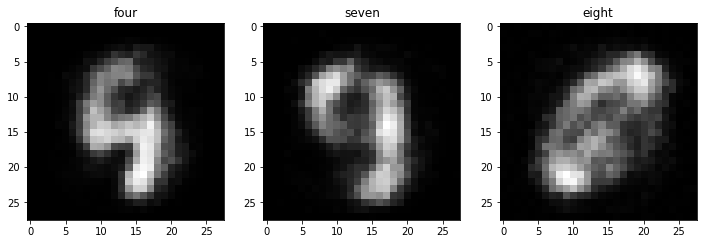

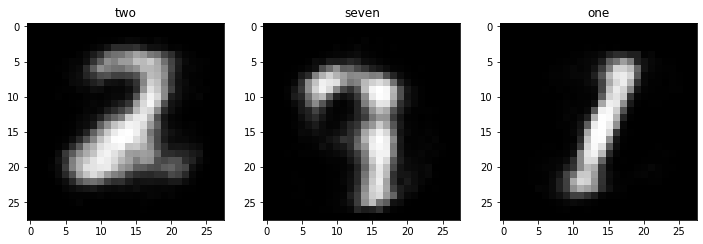

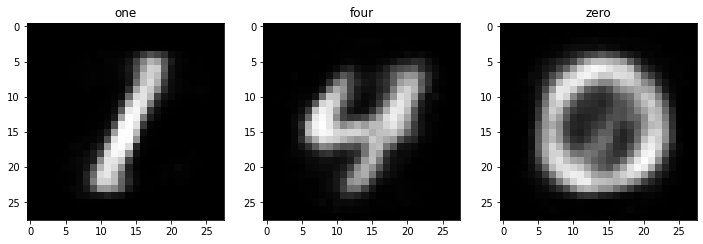

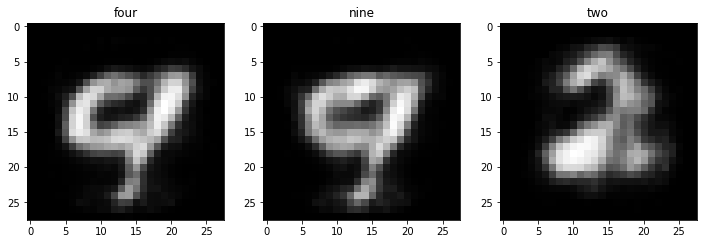

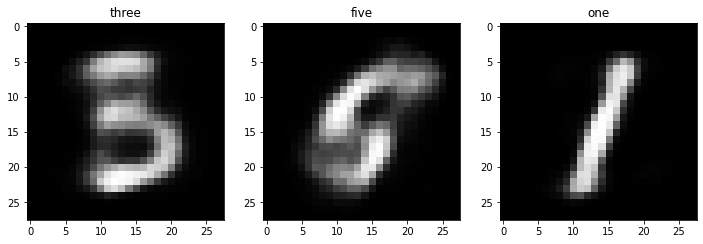

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import random

class RBMachine:
    def __init__(self, visible, hidden, activation, learning_rate=0.001):
        self.visible_num = int(visible)
        self.hidden_num = int(hidden)
        self.learning_rate = learning_rate
        self.afunc = np.vectorize(activation)
        
        #contains the bias term as well
        self.visible = np.empty((1, visible+1))
        self.hidden = np.empty((1, hidden+1))
        self.weights = np.random.uniform(-0.5, 0.5, (visible+1, hidden+1))
        
        #adds bias weights, best way to implement biases
        self.weights[:,0], self.weights[0,:] = 0, 0 
        
    def set_binary_state(self, x):
        return int(random.random() < x)
    
    def check_inputs(self, inputs, single_example=False, hidden=False):
        assert len(inputs.shape) <= 2 and len(inputs.shape) > 0, "Only 2 or 1 dimensions. Given " +str(len(inputs.shape)) + " dimensions" 
        if single_example:
            if hidden: num = self.hidden_num
            else: num = self.visible_num
            if len(inputs.shape) == 2:
                assert inputs.shape == (1, num), "Incorrect size. Wanted "+str((1, num)) + "Given "+str(inputs.shape)
            elif len(inputs.shape) == 1:
                assert num in inputs.shape, "Incorrect size. Wanted "+str((num)) + "Given "+str(inputs.shape)
        else:
            assert len(inputs.shape) == 2, "Must use 2 dimensions when single_example=False (by default)"
            too_small = "Not enough instance features to fill the visible nodes!" + "Visible node count: " + str(self.visible_num) + "Given:"  + str(inputs.shape[1])
            too_big = "Too many instance features for the visible nodes. Don't include the bias." + "Visible node count: " + str(self.visible_num) + "Given:"  + str(inputs.shape[1])
            assert not inputs.shape[1] < self.visible_num, too_small
            assert not inputs.shape[1] > self.visible_num, too_big
            
    #Used for feeding in a single example
    def feed_example(self, input_vector):
        self.check_inputs(input_vector, single_example=True)
        
        if input_vector.shape != (1, self.visible_num):
            input_vector = np.reshape(input_vector, (1, self.visible_num))
            
        input_vector = np.insert(input_vector, 0, 1, axis=1) #adds the bias node
        out, hidden = self.run(input_vector) #runs the example
        
        #removes the bias nodes
        out = np.delete(out, 0, axis=1)
        hidden = np.delete(hidden, 0, axis=1)
        
        return out, hidden
    
    #Single example into the hidden nodes and feed it back to visible nodes
    def feed_hidden(self, hidden, stochastic=True):
        self.check_inputs(hidden, single_example=True, hidden=True)
        
        if hidden.shape != (1, self.hidden_num):
            hidden = np.reshape(hidden, (1, self.hidden_num))
            
        hidden = np.insert(hidden, 0, 1, axis=1)
        out = hidden.dot(self.weights.T)
        
        if stochastic:
            sbs = np.vectorize(self.set_binary_state)
            out = sbs(out)
        out = np.delete(out, 0, axis=1)
        return out
    
    def run(self, input_matrix, hidden_stochastic=True, visible_stochastic=False):
        """Runs an input matrix through through the network to the hidden nodes and back
            to the visible nodes
            
        Parameters
        ----------
        input_matrix: A numpy array of shape (m,n) where n is equal to the number of visible nodes
            excluding bias nodes and m is how many instances there are. Represents a batch of flattened arrays.
            A numpy array of shape (n,) will not work.
            
        hidden_stochastic (default = True): Whether the hidden nodes should choose a binary state or stay as the 
            activation. It will be passed back to the visible nodes as what you choose.True is binary, false 
            is probabilities.
        
        visible_stochastic (default = False): Whether the visible nodes should output binary or probabilities
            on the return from the hidden nodes. True is binary, false is probabilities.
            
        Returns:
        --------
        outputs: The values of the visible nodes of shape (1,n), where n is the
            number of visible nodes.
            
        self.hidden: The hidden node values of the rbm of shape (1,m), where m is the number
            of hidden nodes.
        """
        #Vectorizes the stochastic binary setter function
        sbs = np.vectorize(self.set_binary_state)

        #Runs the input vector through the weight matrix
        node_inputs = input_matrix.dot(self.weights)

        #Activates the inputs 
        hidden_pre_binary = self.afunc(node_inputs)
        
        #Changes the activations into binary, chance of being one is equal to the activation output
        if hidden_stochastic: self.hidden = sbs(hidden_pre_binary)
        else: self.hidden = hidden_pre_binary
        self.hidden[:,0] = 1 #set the bias 'node' to 1
        
        #Does the reverse pass using the hidden node values
        outputs = self.hidden.dot(self.weights.T)       
        outputs = self.afunc(outputs)
        if visible_stochastic: outputs = sbs(outputs)
        return outputs, self.hidden
    
    def contrastive_divergence(self, input_matrix, steps, answer=None, weight_cost=0.01,):
        self.check_inputs(input_matrix)
        
        data_v = None
        data_h = None
        recon_v = None
        recon_h = None

        #adds the bias to the data, and potentially answers
        input_matrix = np.insert(input_matrix, 0, 1, axis=1)
        if answer is not None:
            answer = np.insert(answer, 0 ,1, axis=1)
        
        #performs contrastive divergence for set amount of steps
        for i in range(steps): 
            #Run through of the original data
            if i == 0: 
                data_v = input_matrix
                recon_v, data_h = self.run(input_matrix, visible_stochastic=True)
                if answer is not None: data_h = answer
                recon_v[:,0] = 1 #set the bias 'node' to 1       
                _, recon_h = self.run(recon_v, hidden_stochastic=False)   
            #Run through of reconstruction data
            elif i < steps-2: 
                recon_v, _ =self.run(recon_v, visible_stochastic=False, hidden_stochastic= False)
            #Go throughs this on the last step
            else:
                sbs = np.vectorize(self.set_binary_state)
                recon_v = sbs(recon_v)
                recon_v[:,0] = 1 #set the bias 'node' to 1       
                _, recon_h = self.run(recon_v, hidden_stochastic=False)        

        data_total = data_v.T.dot(data_h)
        recon_total = recon_v.T.dot(recon_h)
        self.weights += self.learning_rate*(data_total - recon_total)
        
    def persistent_contrastive_divergence(self, input_matrix, reconstruction=None, answer=None):
        self.check_inputs(input_matrix)
        
        if answer is not None:
            answer = np.insert(answer, 0 ,1, axis=1)
        
        input_matrix = np.insert(input_matrix, 0, 1, axis=1)
        
        data_v = input_matrix
        recon_v, data_h = self.run(input_matrix)
        if answer is not None: data_h = answer
        if reconstruction is not None:
            recon_v = reconstruction
        new_recon_v, recon_h = self.run(recon_v, visible_stochastic=True)
        
        data_total = data_v.T.dot(data_h)
        recon_total = recon_v.T.dot(recon_h)
        self.weights += self.learning_rate*(data_total - recon_total)
        
        return new_recon_v
          
        
        
def sigmoid(x):
    try:
        return 1/(1+math.exp(-x))
    except:
        print(x)
        assert False
        
#Taken from github
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, int(np.ceil(n_images/float(cols))), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * (n_images-1))
    plt.show()

def test_rbm(rbm, epochs):
    three_2d = np.array([[1,1,1], [0,0,1], [1,1,1], [0,0,1], [1,1,1]])
    five_2d = np.array([[1,1,1], [1,0,0], [1,1,1], [0,0,1], [1,1,1]])
    one_2d = np.array([[0,1,0], [0,1,0], [0,1,0], [0,1,0], [0,1,0]])
    fig = plt.figure()
    
    #use reshape not flatten to avoid those weird (n,) shape arrays
    one = np.reshape(one_2d, (15))
    three = np.reshape(three_2d, (15))
    five = np.reshape(five_2d, (15))
    inputs = []
    inputs.append(three)
    inputs.append(one)
    inputs = np.asarray(inputs)
    
    for i in range(epochs):
        rbm.contrastive_divergence(inputs, 3)
        if i % (epochs/4) == 0 or i == epochs-1:
            t, _ = rbm.feed_example(three)
            o, _ = rbm.feed_example(one)
            t_2d = t.reshape(5,3)
            o_2d = o.reshape(5,3)
            show_images([t_2d, o_2d], titles=["three", "one"])

#USED FOR BASIC TESTING PURPOSES ONLY
#sig = sigmoid
#rbm = RBMachine(15, 2, sig)
#test_rbm(rbm, 110)
 
def test_mnist_digits():
    answer_list =["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
    rbm = RBMachine(784,28, sigmoid)
    digits_train = pd.read_csv(r'E:\Machine Learning & A.I\MNIST digits\mnist_train.csv', header=None)
    digits_train = digits_train.sample(frac=1)
    digits_np = digits_train.to_numpy(dtype='float16')
    answers_np = np.zeros((digits_np.shape[0],10))
    
    for i in range(digits_np.shape[0]):
        x = int(digits_np[i][0])
        answers_np[i][x] = 1
        
    digits_np = np.delete(digits_np, 0, axis=1)
    digits_np /= 255

    size = digits_np.shape[0]
    batch_size = 250
    epochs = 5
    cd_steps = 2
    loops = int(size/batch_size)
    if size % batch_size != 0: loops + 1
    
    #images = []
    #for i in range(10):
     #   x = np.zeros((1,10))
      #  x[0][i] = 1
       # out = rbm.feed_hidden(x, stochastic=False)
        #out_2d = out.reshape(28,28)
        #images.append(out_2d)
    #show_images(images)
    
    for i in range(epochs):
        total = 0
        reconstruction = None
        for _ in range(loops):
            if batch_size + total >= size:
                reconstruction = rbm.persistent_contrastive_divergence(digits_np[total:], 
                                            reconstruction=reconstruction)#, answer=answers_np[total:])
                #rbm.contrastive_divergence(digits_np[total:], cd_steps)#, answer=answers_np[total:])
            else:
                reconstruction = rbm.persistent_contrastive_divergence(digits_np[total:(total+batch_size)], 
                                reconstruction=reconstruction)#, answer=answers_np[total:(total+batch_size)])
                #rbm.contrastive_divergence(digits_np[total:(total+batch_size)], cd_steps)#, 
                                                #answer=answers_np[total:(total+batch_size)])
            total += batch_size
        
        
        images = []
        labels = []
        for i in range(3):
            rando = random.randint(0,2000)
            index = np.where(answers_np[rando] == 1)
            labels.append(answer_list[index[0][0]])
            x = digits_np[rando]
            y, _ = rbm.feed_example(x)
            y_2d = y.reshape(28,28)
            images.append(y_2d)
        show_images(images, titles=labels)
    #images = []
    #for i in range(10):
    #    x = np.zeros((1,10))
    #    x[0][i] = 1
    #    out = rbm.feed_hidden(x, stochastic=False)
    #    out_2d = out.reshape(28,28)
    #    images.append(out_2d)
    
        

test_mnist_digits() 
